# Exploratory Data Analysis

project description here

## 1. Import Libraries dan Load Datasets

In [111]:
# import standard libraries
import numpy as np
import pandas as pd
import glob
import math
import time
import os

import warnings
warnings.filterwarnings("ignore")

In [137]:
## import statistical library
from scipy.stats import spearmanr
from scipy import stats
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import adfuller

In [113]:
# import viz packages
import plotly.express as px
import plotly.graph_objects as go
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import altair as alt

Load preprocessed dataset

In [114]:
# set file path
file_path = "../datasets/processed/daily-pm25-gsod-cleaned.csv"

In [115]:
# load data
## parses_dates kolom tanggal dan jadikan sebagai index
df = pd.read_csv(file_path,parse_dates=["tanggal"],
                        index_col=["tanggal"])

df

,lokasi,pm25,aqi,kategori,temperatur,curah_hujan,jarak_pandang,kecepatan_angin
tanggal,,,,,,,,
2016-01-01,Jakarta Selatan,22.30,72.5,Sedang,28.11,0.00,4.1,3.3
2016-01-01,Jakarta Pusat,31.40,91.6,Sedang,28.11,0.00,4.1,3.3
2016-01-02,Jakarta Pusat,31.00,90.7,Sedang,27.44,15.24,3.9,3.2
2016-01-02,Jakarta Selatan,37.05,104.8,Tidak Sehat Untuk Kelompok Rentan,27.44,15.24,3.9,3.2
2016-01-03,Jakarta Selatan,18.65,64.8,Sedang,29.00,0.00,4.3,3.6
...,...,...,...,...,...,...,...,...
2022-11-21,Jakarta Selatan,35.50,50.2,Baik,28.78,0.00,4.0,2.6
2022-11-22,Jakarta Pusat,8.70,36.2,Baik,28.78,0.00,4.0,2.6
2022-11-23,Jakarta Pusat,17.25,61.8,Sedang,28.78,0.00,4.0,2.6


Project ini akan coba memfokuskan pada konsentrasi PM 2.5 di Jakarta Pusat, oleh karena itu filter dataset dan ambil hanya sensor yang lokasinya di Jakarta Pusat.

In [116]:
df_jakpus = df.query("lokasi == 'Jakarta Pusat'")

df_jakpus.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2521 entries, 2016-01-01 to 2022-11-25
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   lokasi           2521 non-null   object 
 1   pm25             2521 non-null   float64
 2   aqi              2521 non-null   float64
 3   kategori         2521 non-null   object 
 4   temperatur       2521 non-null   float64
 5   curah_hujan      2521 non-null   float64
 6   jarak_pandang    2521 non-null   float64
 7   kecepatan_angin  2521 non-null   float64
dtypes: float64(6), object(2)
memory usage: 177.3+ KB


## 2. EDA

### 2.1 Temperatur vs Konsentrasi PM 2.5

In [117]:
alt.themes.enable('dark')


base = alt.Chart(title=alt.TitleParams(
        text="Temperatur Permukaan dan Konsentrasi Polusi PM 2.5 di Jakarta Pusat",
        subtitle=["Pada periode musim tertentu, temperatur permukaan terlihat memiliki korelasi yang cukup kuat dengan konsentrasi polusi",
                  "PM 2.5 di Jakarta Pusat. Temperatur sendiri diketahui dapat mempengaruhi pembentukan partikel di udara; karenanya, temperatur",
                  "permukaan yang tinggi dapat meningkatkan reaksi fotokimia antar prekursor. Dapat dilihat di periode akhir hingga awal tahun,",
                  "menurunnya rata-rata temperatur permukaan diiringi dengan menurunnya rata-rata konsentrasi polusi PM 2.5. Korelasi",
                  "antara kedua variable ini tidak dapat disimpulkan sebagai hubungan sebab-akibat."],
                  align="left", anchor="start", baseline="line-top", fontSize=18, subtitleFontSize=14)).encode(
    alt.X("tanggal", timeUnit="yearmonth", type="ordinal", axis=alt.Axis(title=None, format="%b %Y"))
).properties(
    width=800, height=400
)

bar = base.mark_bar(opacity=0.5, color='#f34213').encode(
    alt.Y('median(pm25)',
          title=["Rata-Rata Konsentrasi PM 2.5 (μg/m\u00b3)", "Selama 1 Bulan"])
)

line = base.mark_line(stroke='white', interpolate='monotone').encode(
    alt.Y('median(temperatur)',
          title=["Rata-Rata Temperatur Permukaan (°C)", "Selama 1 Bulan"],
          scale=alt.Scale(domain=[24, 32]))
)

chart1 = alt.layer(bar, line).resolve_scale(
    y = 'independent'
)

points = alt.Chart().mark_point(opacity=0.5, color='#f34213').encode(
    x=alt.X('temperatur:Q', title=["Rata-Rata Temperatur Permukaan (°C)", "Selama 24 Jam"],
            scale=alt.Scale(domain=[24,32])),
    y=alt.Y('pm25:Q', title=["Rata-Rata Konsentrasi PM 2.5 (μg/m\u00b3)", "Selama 24 Jam"])
)


chart2 = points + points.transform_loess(bandwidth=0.3, 
                            loess = "pm25", on="temperatur"
).mark_line(
    color='white',
    size=2
).properties(
    width=800, # lebar
    height=300 # tinggi
)


alt.vconcat(
    chart1, # overlay garis di scatter plot
    chart2,
    data=df_jakpus.reset_index() # reset index supaya datetime index jadi kolom
).configure_view(
    strokeWidth=0
).configure_title(
    frame='group'
).configure_axis(
    labelFontSize=12,
    titleFontSize=12,
    grid=False
).properties(
    title=alt.TitleParams(
        ['Sumber data: U.S Embassy, Jakarta Air Quality Monitor (Jakarta Pusat) dan NCEI, Global Surface Summary of the Day (GSOD).', 
        'Periode pengukuran 1 Januari 2016 sampai 25 November 2022 selama 24 jam.',
        "Catatan: Warna merah pada grafik merepresentasikan konsentrasi PM 2.5, sementara garis warna putih merepresentasikan temperatur permukaan."],
        baseline='bottom',
        orient='bottom',
        anchor='start',
        fontWeight='normal',
        fontSize=12,
        offset=30
    )
)

alt.VConcatChart(...)

Hypothesis Testing

Null hypothesis (H0): bahwa antara konsentrasi polusi tidak memiliki korelasi dengan temperatur udara. H0 akan diteirma apabila P-value di atas 0.05, yang mana berarti konsentrasi polusi tidak memiliki korelasi dengan temperatur udara. Jika P-value kurang atau di bawah dari 0.05, maka berarti konsentrasi polusi memiliki korelasi dengan temperatur udara.

In [118]:
print("Null hypothesis (H0): Konsentrasi polusi PM 2.5 tidak memiliki korelasi dengan temperatur permukaan.")
print("H0 akan diterima apabila P-Value di atas 0.05, yang mana berarti konsentrasi polusi PM 2.5 tidak memiliki \nkorelasi dengan temperatur permukaan. Jika P-value kurang atau di bawah dari 0.05, \nmaka berarti konsentrasi polusi PM 2.5 memiliki korelasi dengan temperatur permukaan.\n")
print("#######################################################\n")
print("Kalkulasi menggunakan\x1B[3m Spearman Correlation\x1B[0m .... \n")
coef, p = spearmanr(df_jakpus["pm25"], df_jakpus["temperatur"])
print("#######################################################\n")
alpha = 0.05
if p > alpha:
	print('Sampel tidak memiliki korelasi (H0 tidak dapat ditolak) \nP-Value =', p, "\nKoefisien = ", coef)
else:
	print('Sampel memiliki korelasi (H0 dapat ditolak) \nP-Value =', p, "\nKoefisien = ", coef)

Null hypothesis (H0): Konsentrasi polusi PM 2.5 tidak memiliki korelasi dengan temperatur permukaan.
H0 akan diterima apabila P-Value di atas 0.05, yang mana berarti konsentrasi polusi PM 2.5 tidak memiliki 
korelasi dengan temperatur permukaan. Jika P-value kurang atau di bawah dari 0.05, 
maka berarti konsentrasi polusi PM 2.5 memiliki korelasi dengan temperatur permukaan.

#######################################################

Kalkulasi menggunakan Spearman Correlation .... 

#######################################################

Sampel memiliki korelasi (H0 dapat ditolak) 
P-Value = 1.2165033909251726e-52 
Koefisien =  0.29736246336870575


### 2.2 Kecepatan Angin vs Konsentrasi PM 2.5

In [119]:
base = alt.Chart(title=alt.TitleParams(
        text="Kecepatan Angin dan Konsentrasi Polusi PM 2.5 di Jakarta Pusat",
        subtitle=["Tinggi-rendahnya kecepatan angin pada periode musim tertentu memiliki korelasi dengan konsentrasi polusi PM 2.5 di Jakarta",
                  "Pusat. Pada akhir dan awal tahun dimana merupakan periode musim penghujan, rata-rata kecepatan angin terlihat lebih tinggi",
                  "dan rata-rata konsentrasi polusi PM 2.5 terlihat menurun. Sebaliknya, pada saat rata-rata kecepatan angin yang bertiup menurun",
                  "pada periode musim kemarau, konsentrasi polusi PM 2.5 yang terekam meningkat dengan tajam. Sebagai catatan, tinggi-rendahnya",
                  "kecepatan angin pada visualisasi berikut hanya menunjukkan korelasinya dengan konsentrasi PM 2.5, bukan sebagai kausalitas."],
                  align="left", anchor="start", baseline="line-top", fontSize=18, subtitleFontSize=14, offset=20)).encode(
    alt.X("tanggal", timeUnit="yearmonth", type="ordinal", axis=alt.Axis(title=None, format="%b %Y"))
).properties(
    width=800, height=400
)

bar = base.mark_bar(opacity=0.5, color='#f34213').encode(
    alt.Y('median(pm25)',
          title=["Rata-Rata Konsentrasi PM 2.5 (μg/m\u00b3)", "Selama 1 Bulan"])
)

line = base.mark_line(stroke='white', interpolate='monotone').encode(
    alt.Y('median(kecepatan_angin)',
          title=["Rata-Rata Kecepatan Angin (knots)", "Selama 1 Bulan"])
)

chart1 = alt.layer(bar, line).resolve_scale(
    y = 'independent'
)

points = alt.Chart().mark_point(opacity=0.5, color='#f34213').encode(
    x=alt.X('kecepatan_angin:Q', title=["Rata-Rata Kecepatan Angin (knots)", "Selama 24 Jam"]),
    y=alt.Y('pm25:Q', title=["Rata-Rata Konsentrasi PM 2.5 (μg/m\u00b3)", "Selama 24 Jam"])
)


chart2 = points + points.transform_loess(bandwidth=0.3, 
                            loess = "pm25", on="kecepatan_angin"
).mark_line(
    color='white',
    size=2
).properties(
    width=800, # lebar
    height=300 # tinggi
)


alt.vconcat(
    chart1, # overlay garis di scatter plot
    chart2,
    data=df_jakpus.reset_index() # reset index supaya datetime index jadi kolom
).configure_view(
    strokeWidth=0
).configure_title(
    frame='group'
).configure_axis(
    labelFontSize=12,
    titleFontSize=12,
    grid=False
).properties(
    title=alt.TitleParams(
        ['Sumber data: U.S Embassy, Jakarta Air Quality Monitor (Jakarta Pusat) dan NCEI, Global Surface Summary of the Day (GSOD).', 
        'Periode pengukuran 1 Januari 2016 sampai 25 November 2022 selama 24 jam.',
        "Catatan: Warna merah pada grafik merepresentasikan konsentrasi PM 2.5, sementara garis warna putih merepresentasikan kecepatan angin."],
        baseline='bottom',
        orient='bottom',
        anchor='start',
        fontWeight='normal',
        fontSize=12,
        offset=30
    )
)

alt.VConcatChart(...)

Hypothesis Testing

In [120]:
print("Null hypothesis (H0): Konsentrasi polusi PM 2.5 tidak memiliki korelasi dengan kecepatan angin.")
print("H0 akan diterima apabila P-Value di atas 0.05, yang mana berarti konsentrasi polusi PM 2.5 tidak memiliki \nkorelasi dengan kecepatan angin. Jika P-value kurang atau di bawah dari 0.05, \nmaka berarti konsentrasi polusi PM 2.5 memiliki korelasi dengan kecepatan angin.\n")
print("#######################################################\n")
print("Kalkulasi menggunakan\x1B[3m Spearman Correlation\x1B[0m .... \n")
coef, p = spearmanr(df_jakpus["pm25"], df_jakpus["kecepatan_angin"])
print("#######################################################\n")
alpha = 0.05
if p > alpha:
	print('Sampel tidak memiliki korelasi (H0 tidak dapat ditolak) \nP-Value =', p, "\nKoefisien = ", coef)
else:
	print('Sampel memiliki korelasi (H0 dapat ditolak) \nP-Value =', p, "\nKoefisien = ", coef)

Null hypothesis (H0): Konsentrasi polusi PM 2.5 tidak memiliki korelasi dengan kecepatan angin.
H0 akan diterima apabila P-Value di atas 0.05, yang mana berarti konsentrasi polusi PM 2.5 tidak memiliki 
korelasi dengan kecepatan angin. Jika P-value kurang atau di bawah dari 0.05, 
maka berarti konsentrasi polusi PM 2.5 memiliki korelasi dengan kecepatan angin.

#######################################################

Kalkulasi menggunakan Spearman Correlation .... 

#######################################################

Sampel memiliki korelasi (H0 dapat ditolak) 
P-Value = 1.4593033867656637e-38 
Koefisien =  -0.2545020456483328


### 2.3 Curah Hujan vs Konsentrasi PM 2.5

In [121]:
base = alt.Chart(title=alt.TitleParams(
        text="Curah Hujan dan Konsentrasi Harian Polusi PM 2.5 di Jakarta Pusat",
        subtitle=["Benarkah intensitas curah hujan dapat mengurangi konsentrasi polutan PM 2.5 di udara? Visualisasi data berikut",
                  "mencoba untuk menampilkan apakah terdapat korelasi antara dua kejadian tersebut menggunakan data historikal dari",
                  "konsentrasi PM 2.5 dan curah hujan yang tercatat di Jakarta Pusat."],
                  align="left", anchor="start", baseline="line-top", fontSize=18, subtitleFontSize=14)).encode(
    alt.X("tanggal", timeUnit="yearmonth", type="ordinal", axis=alt.Axis(title=None, format="%b %Y"))
).properties(
    width=800, height=400
)

bar = base.mark_bar(opacity=0.5, color='#f34213').encode(
    alt.Y('mean(pm25):Q',
          title=["Rata-Rata Konsentrasi PM 2.5 (μg/m\u00b3)", "Selama 1 Bulan"])
)

line = base.mark_line(stroke='white', interpolate='monotone').encode(
    alt.Y('mean(curah_hujan):Q',
          title=["Rata-Rata Curah Hujan (mm)", "Selama 1 Bulan"])
)

chart1 = alt.layer(bar, line).resolve_scale(
    y = 'independent'
)

points = alt.Chart().mark_point(opacity=0.5, color='#f34213').encode(
    x=alt.X('curah_hujan:Q', title=["Rata-Rata Curah Hujan (°C)", "Selama 24 Jam"]),
    y=alt.Y('pm25:Q', title=["Rata-Rata Konsentrasi PM 2.5 (μg/m\u00b3)", "Selama 24 Jam"])
)


chart2 = points + points.transform_loess(bandwidth=0.6, 
                            loess = "pm25", on="curah_hujan"
).mark_line(
    color='white',
    size=2
).properties(
    width=800, # lebar
    height=300 # tinggi
)


alt.vconcat(
    chart1, # overlay garis di scatter plot
    chart2,
    data=curah_hujan.reset_index() # reset index supaya datetime index jadi kolom
).configure_view(
    strokeWidth=0
).configure_title(
    frame='group'
).configure_axis(
    labelFontSize=12,
    titleFontSize=12,
    grid=False
).properties(
    title=alt.TitleParams(
        ['Sumber data: U.S Embassy, Jakarta Air Quality Monitor (Jakarta Pusat) dan NCEI, Global Surface Summary of the Day (GSOD).', 
        'Periode pengukuran 1 Januari 2016 sampai 25 November 2022 selama 24 jam.',
        "Catatan: Warna merah pada grafik merepresentasikan konsentrasi PM 2.5, sementara garis warna putih merepresentasikan curah hujan."],
        baseline='bottom',
        orient='bottom',
        anchor='start',
        fontWeight='normal',
        fontSize=12,
        offset=30
    )
)

alt.VConcatChart(...)

In [122]:
print("Null hypothesis (H0): Konsentrasi polusi PM 2.5 tidak memiliki korelasi dengan intensitas curah hujan.")
print("H0 akan diterima apabila P-Value di atas 0.05, yang mana berarti konsentrasi polusi PM 2.5 tidak memiliki \nkorelasi dengan intensitas curah hujan. Jika P-value kurang atau di bawah dari 0.05, \nmaka berarti konsentrasi polusi PM 2.5 memiliki korelasi dengan intensitas curah hujan.\n")
print("#######################################################\n")
print("Kalkulasi menggunakan\x1B[3m Spearman Correlation\x1B[0m .... \n")
coef, p = spearmanr(df_jakpus["pm25"], df_jakpus["curah_hujan"])
print("#######################################################\n")
alpha = 0.05
if p > alpha:
	print('Sampel tidak memiliki korelasi (H0 tidak dapat ditolak) \nP-Value =', p, "\nKoefisien = ", coef)
else:
	print('Sampel memiliki korelasi (H0 dapat ditolak) \nP-Value =', p, "\nKoefisien = ", coef)

Null hypothesis (H0): Konsentrasi polusi PM 2.5 tidak memiliki korelasi dengan intensitas curah hujan.
H0 akan diterima apabila P-Value di atas 0.05, yang mana berarti konsentrasi polusi PM 2.5 tidak memiliki 
korelasi dengan intensitas curah hujan. Jika P-value kurang atau di bawah dari 0.05, 
maka berarti konsentrasi polusi PM 2.5 memiliki korelasi dengan intensitas curah hujan.

#######################################################

Kalkulasi menggunakan Spearman Correlation .... 

#######################################################

Sampel memiliki korelasi (H0 dapat ditolak) 
P-Value = 3.437432464565862e-27 
Koefisien =  -0.2127396519978745


### 2.4 Correlation Matrix

In [123]:
corrMatrix = df_jakpus[["pm25", "temperatur", "curah_hujan", "kecepatan_angin", "jarak_pandang"]]
corrMatrix = corrMatrix.corr().reset_index().melt('index')
corrMatrix.columns = ['var1', 'var2', 'correlation']
corrMatrix

,var1,var2,correlation
0,pm25,pm25,1.000000
1,temperatur,pm25,0.296564
2,curah_hujan,pm25,-0.111594
3,kecepatan_angin,pm25,-0.292139
4,jarak_pandang,pm25,0.099332
5,pm25,temperatur,0.296564
6,temperatur,temperatur,1.000000
7,curah_hujan,temperatur,-0.392793
8,kecepatan_angin,temperatur,0.051347
9,jarak_pandang,temperatur,0.380791


In [124]:
alt.themes.enable('latimes')

base = alt.Chart(corrMatrix).transform_filter(
    alt.datum.var1 < alt.datum.var2
).encode(
    x=alt.X("var1", title=""),
    y=alt.Y("var2", title="")
).properties(
    width=alt.Step(100),
    height=alt.Step(100)
)

rects = base.mark_rect().encode(
    color="correlation"
)

text = base.mark_text(
    size=30
).encode(
    text=alt.Text('correlation', format=".2f"),
    color=alt.condition(
        "datum.correlation > 0.5",
        alt.value('white'),
        alt.value('black')
    )
)

rects + text

alt.LayerChart(...)

Dengan menampilkan correlation matrix seperti gambar di atas, terlihat jika PM 2.5 memiliki korelasi positif yang cukup moderat dengan temperatur udara dan korelasi negatif yang juga cukup moderat dengan kecapatan angin. Sedangkan dengan jarak pandang dan curah hujan, konsentrasi PM 2.5 terlihat memiliki korelasi yang lemah.

## 3. In-depth Analysis

In [138]:
alt.themes.enable('dark')

## set scale
scale= alt.Scale(domain=["Baik", "Sedang", "Tidak Sehat Untuk Kelompok Rentan", "Tidak Sehat"],
                 range=["#4ba3c3", "#fcba04", "#F88379", "#f34213"]) # warna untuk masing-masing kategori

## set kategori
color = alt.Color("kategori:N", scale=scale,
                  legend=alt.Legend(title="Kategori Kualitas Udara",
                                    titleFontSize=12, labelFontSize=12,
                                    titleLimit=200, labelLimit=200, orient="right", offset=-30))  # parameter legend

## set brush dan selection untuk interaktif
brush = alt.selection_interval(encodings=['x'])
click = alt.selection_multi(encodings=['color'])

## set top panel; scatter plot
## x-axis=timeseries, y-axis=konsentrasi pm25
points = alt.Chart(title=alt.TitleParams(text="Jakarta Pusat, Polusi PM 2.5, dan Kualitas Udara Harian",
                                         subtitle=["Visualisasi berikut menampilkan distribusi konsentrasi harian dari polusi PM 2.5 di Jakarta Pusat sepanjang 1 Januari 2016 hinga 25 November 2022.",
                                                   "Nilai konsentrasi harian terlihat memiliki tren peningkatan di pertengahan tahun dan mayoritas nilai konsentrasi di atas ambang batas harian yang telah",
                                                   "direkomendasikan oleh WHO. Tahun berganti, namun kualitas udara di Jakarta Pusat seringkali tidak ramah bagi mereka yang masuk ke dalam kelompok rentan.", 
                                                   "Bahkan Pandemi COVID-19 nampaknya tidak memiliki banyak pengaruh untuk menurunkan tingginya konsentrasi polusi PM 2.5 yang terus berlangsung.",
                                                   "Kualitas udara dikonversi dari nilai rata-rata konsentrasi harian polusi PM 2.5 selama 24 jam."],
                                         align="left", baseline="middle", fontSize=20, subtitleFontSize=14, offset=10, anchor="start")).mark_point().encode(
    x=alt.X("tanggal:T", timeUnit="yearmonthdate", title="  ",
            axis=alt.Axis(tickCount=8, format="%b %Y")), # set x-axis, scatter points perhari tapi display hanya label bulan-tahun di x-ticks
    y=alt.Y("pm25", title=["Konsentrasi PM 2.5 (μg/m\u00b3)", "Selama 24 Jam"],
            scale=alt.Scale(domain=[0, 150])), #set y-axis konsentrasi pm2.5
    color=alt.condition(brush, color, alt.value("lightgray")) # kalau selection true, warna sesuai color scale, kalau selection false akan berwarna abu-abu
).properties(
    width=1000, # lebar
    height=400 # tinggi
).add_selection(
    brush # set selection
).transform_filter(
    click # set transform
)

## set bottom panel; bar plot
## x-axis=jumlah observasi, y-axis=nama kategori
bars = alt.Chart(title=alt.TitleParams(text="",
                                       align="left", baseline="middle", fontSize=12, offset=-5, anchor="start",
                                       )).mark_bar().encode(
    x=alt.X("count()", title="Frekuensi Dalam Satuan Hari"), # x-axis, hitung frekuensi kategori 
    y=alt.Y("kategori:N", title="",
            sort=["Tidak Sehat", "Tidak Sehat Untuk Kelompok Rentan", "Sedang", "Baik"]), # y-axis, naam kategori yang diurutkan sesuai urutan scatter plot
    color=alt.condition(click, color, alt.value('lightgray')) # kalau selection true, warna sesuai color scale, kalau selection false akan berwarna abu-abu
).properties(
    width=1000, # lebar
    height=75 # tinggi
).add_selection(
    click # set selection
).transform_filter(
    brush # set transform
)

## set garis putus untuk limit konsentrasi harian who
yrule1 = (
    alt.Chart().mark_rule(color="lightgray", strokeDash=[15, 15], size=1.5, opacity=0.4).encode(y=alt.datum(15))
)

## set garis pertama kali psbb dimulai
xrule = (
    alt.Chart().mark_rule(color="lightgray", strokeDash=[15, 15],
                          size=1.5, opacity=0.3).encode(
                              x=alt.datum(alt.DateTime(year=2020, month="April", date=10)))
)

bar1 = alt.Chart(title=alt.TitleParams(text="",
                                       align="left", anchor="middle" , fontSize=12, offset=5
                                       )).mark_bar().transform_calculate(
    order="{'Baik': 0, 'Sedang': 1, 'Tidak Sehat Untuk Kelompok Rentan': 2, 'Tidak Sehat': 3}[datum.kategori]").encode(
    x=alt.X('month(tanggal):N', title=''),
    y=alt.Y("count()", title="Proporsi", stack="normalize", axis=alt.Axis(format='%')),
    column=alt.Column("tanggal", timeUnit="year", type="ordinal", title="",
                      header=alt.Header(labelFontSize=12, labelBaseline="top")),
    color=alt.Color('kategori', scale=scale),
    order='order:O'
).properties(
    width=125,height=125
)

# # add arb text
# text1 = alt.Chart({'values':[{'x':5, 'y':5}]}).mark_text(
#     text="test text"
# ).encode(
#     x="x:Q", y="y:Q"
# )

# text5 = alt.Chart({'values':[{'x': 20, 'y': 100}]}).mark_text(
#     text='doubles every 5 days', angle=346
# ).encode(
#     x='x:Q', y='y:Q'
# )


## gabung jadi satu vertical
alt.vconcat(
    points+yrule1+xrule,
    bar1, 
    bars, # overlay garis di scatter plot
    data=df_jakpus.reset_index(),
    center=True # reset index supaya datetime index jadi kolom
).configure_axis(
    labelFontSize=12, # label di axis
    titleFontSize=14, # title di axis
    grid=False
).configure_view(strokeWidth=0).configure_title(frame='group').properties(
    title=alt.TitleParams(
        ['Sumber data: U.S Embassy, Jakarta Air Quality Monitor (Jakarta Pusat).', 
        'Periode pengukuran 1 Januari 2016 sampai 25 November 2022, interval pengukuran setiap 1 jam.',
        'Garis putus vertikal berwarna putih menandakan periode awal dimulai PPKM di Jakarta, sedangkan',
        'garis putus horizontal berwarna putih adalah ambang batas kosentrasi PM 2.5 harian rekomendasi dari WHO.'],
        baseline='bottom',
        orient='bottom',
        anchor='start',
        fontWeight='normal',
        fontSize=12,
        offset=20
    )
)

alt.VConcatChart(...)

In [126]:
alt.themes.enable('dark')
alt.Chart(df_jakpus.reset_index()).mark_rect().encode(
    x=alt.X("tanggal", timeUnit="year", type="ordinal", title="Tahun"),
    y=alt.Y("tanggal", timeUnit="month", type="ordinal", title="Bulan"),
    color=alt.Color("average(pm25)", scale=alt.Scale(scheme="inferno", reverse=True),
                    legend=alt.Legend(title=["Konsentrasi", "PM 2.5 (μg/m\u00b3)", "Harian"])),
    tooltip=[alt.Tooltip("average(pm25)", title="PM 2.5 (ug/m3)")]
).properties(
    width=1000, height=700,
    title=alt.TitleParams(
        text="Semakin Gelap, Semakin Tidak Sehat Untuk Pernafasan Anda",
        subtitle=["Melihat rata-rata konsentrasi dari polusi PM 2.5 setiap bulan di Jakarta Pusat sepanjang 1 Januari 2016 hingga 25 November 2022. Semakin gelap warna kotak, maka ", 
                  "semakin tinggi pula rata-rata konsentrasi harian selama periode satu bulan dari PM 2.5 yang direpresentasikan. Bagian kosong di kanan bawah pada gambar ",
                  "merepresentasikan tidak adanya data sampai saat visualisasi ini dibuat. Konsentrasi diukur dalam satuan mikrogram per meter kubik (μg/m\u00b3)."],
                  align="left", anchor="start", baseline="line-top", fontSize=20, subtitleFontSize=14, offset=10)
).configure_view(
    strokeWidth=0
).configure_title(
    frame='group'
).configure_axis(
    labelFontSize=12,
    titleFontSize=14
)

alt.Chart(...)

### Uji Stasioneritas Data Time Series

Uji stasioneritas akan dilakukan dengan menggunakan Dickey-Fuller Test. Metode ini akan melakukan uji unit root, yang merupakan uji untuk mengetahui stasioneritas dari data time series. 
<li>Null Hypothesis (H0): Data menunjukkan memiliki unit root. Data tidak stasioner.</li>
<li>Alternatif Hypothesis (H1): Data menunjukkan tidak memiliki unit root. Data stasioner.</li>

Jika p-value > 0.05, maka null hypothesis (H0) akan diterima, yang mana berarti data tidak stasioner. Jika p-value <= 0.05, maka null hypothesis (H0) dapat ditolak, data tidak memiliki unit root dan stasioner.

In [129]:
pm25_jakpus = df_jakpus.filter(["pm25", "aqi", "kategori"])

pm25_jakpus.head()

,pm25,aqi,kategori
tanggal,,,
2016-01-01,31.40,91.6,Sedang
2016-01-02,31.00,90.7,Sedang
2016-01-03,27.40,83.2,Sedang
2016-01-04,52.80,143.6,Tidak Sehat Untuk Kelompok Rentan
2016-01-05,60.75,153.7,Tidak Sehat


In [134]:
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    
    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

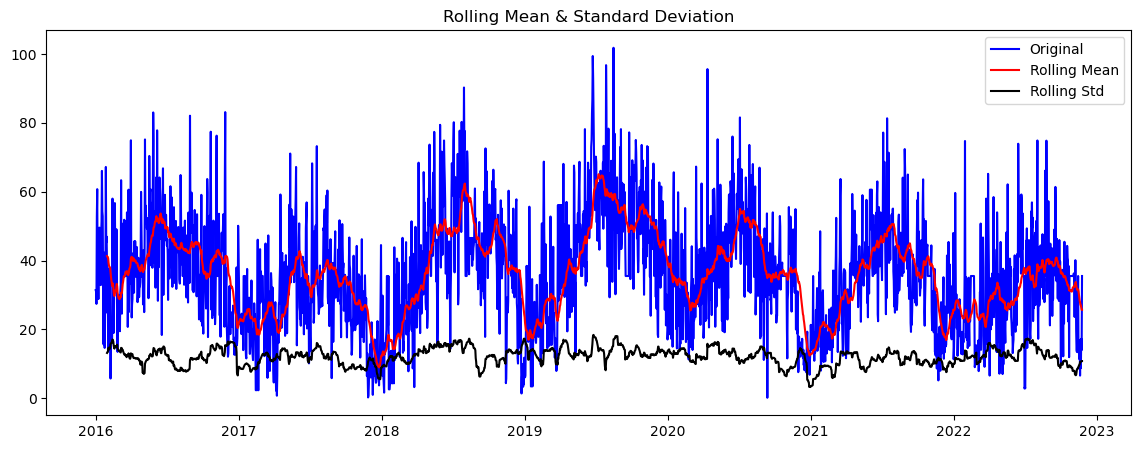

<Results of Dickey-Fuller Test>
Test Statistic                   -5.622607
p-value                           0.000001
#Lags Used                       13.000000
Number of Observations Used    2507.000000
Critical Value (1%)              -3.432961
Critical Value (5%)              -2.862694
Critical Value (10%)             -2.567384
dtype: float64


In [136]:
test_stationarity(pm25_jakpus["pm25"].dropna())

Dickey-Fuller Test di atas menujukkan jika p-value kurang dari 0.05, maka dengan ini null hypothesis (H0) dapat ditolak. Data dapat dikatakan stasioner.